## Training excitatory-inhibitory recurrent network

Here we will train recurrent neural network with excitatory and inhibitory neurons on a simple perceptual decision making task.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gyyang/nn-brain/blob/master/EI_RNN.ipynb)

## Install dependencies

In [1]:
# # If on Google Colab, uncomment to install neurogym to use cognitive tasks
# ! git clone https://github.com/gyyang/neurogym.git
# %cd neurogym/
# ! pip install -e .

## Defining a perceptual decision making task

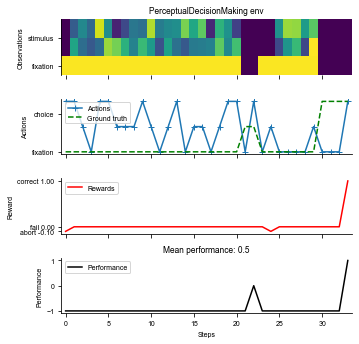

In [1]:
# We will import the task from the neurogym library
import neurogym as ngym

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

## Define E-I recurrent network

Here we define a E-I recurrent network, in particular, no self-connections are allowed.

In [11]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math


class PosWLinear(nn.Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Same as nn.Linear, except that weight matrix is constrained to be non-negative
    """
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(PosWLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        # weight is non-negative
        return F.linear(input, torch.abs(self.weight), self.bias)
    
    
class EIRecLinear(nn.Module):
    r"""Recurrent E-I Linear transformation.
    
    Args:
        hidden_size: int, layer size
        e_prop: float between 0 and 1, proportion of excitatory units
    """
    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size)
        self.i_size = hidden_size - self.e_size
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
        np.fill_diagonal(mask, 0)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale E weight by E-I ratio
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
    
    def effective_weight(self):
        return torch.abs(self.weight) * self.mask

    def forward(self, input):
        # weight is non-negative
        return F.linear(input, self.effective_weight(), self.bias)


class EIRNN(nn.Module):
    """E-I RNN.
    
    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        # self.input2h = PosWLinear(input_size, hidden_size)
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)
        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])

        output = torch.stack(output, dim=0)
        return output, hidden


class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        # self.fc = PosWLinear(self.rnn.e_size, output_size)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

## Train the network on the decision making task

In [18]:
import torch.optim as optim
import numpy as np

# Instantiate the network and print information
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

running_loss = 0
running_acc = 0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output, activity = net(inputs)
    
    output = output.view(-1, output_size)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        running_loss /= print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Step 200, Loss 0.5400
Step 400, Loss 0.3113
Step 600, Loss 0.1957
Step 800, Loss 0.1415
Step 1000, Loss 0.1166
Step 1200, Loss 0.0997
Step 1400, Loss 0.0891
Step 1600, Loss 0.0791
Step 1800, Loss 0.0786
Step 2000, Loss 0.0735
Step 2200, Loss 0.0705
Step 2400, Loss 0.0692
Step 2600, Loss 0.0682
Step 2800, Loss 0.0648
Step 3000, Loss 0.0636
Step 3200, Loss 0.0632
Step 3400, Loss 0.0625
Step 3600, Loss 0.0640
Step 3800, Loss 0.0610
Step 4000, Loss 0.0606
Step 4200, Loss 0.0591
Step 4400, Loss 0.0607
Step 4600, Loss 0.0587
Step 4800, Loss 0.0604
Step 5000, Loss 0.0586


## Run the network post-training and record neural activity

In [19]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)
    
    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]
    
    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    
    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)
    
print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.848


### Plot neural activity from sample trials

Text(0, 0.5, 'Activity')

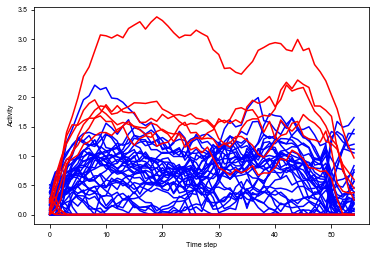

In [23]:
import matplotlib.pyplot as plt

e_size = net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

### Compute stimulus selectivity for sorting neurons

Here for each neuron we compute its stimulus period selectivity $d'$

In [24]:
mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))

### Plot network connectivity sorted by stimulus selectivity

Text(0.5, 1.0, 'Network connectivity')

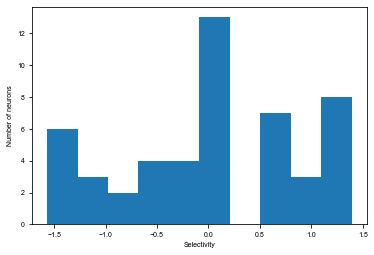

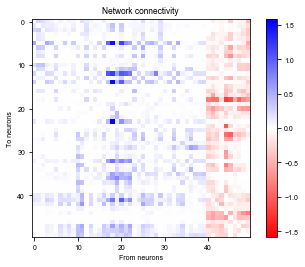

In [25]:
# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

# Supplementary Materials

Code for making publication quality figures as it appears in the paper.

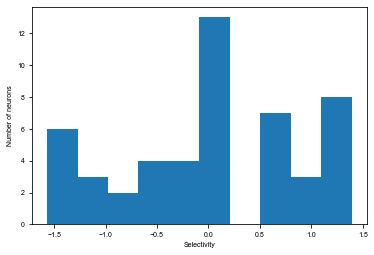

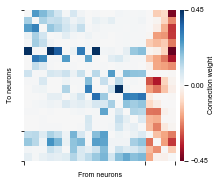

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_e = 8
plot_i = int(plot_e / 4)
plot_total = (plot_e + plot_i) * 2

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((
    np.argsort(selectivity[:e_size])[:plot_e],
    np.argsort(selectivity[:e_size])[-plot_e:],
    np.argsort(selectivity[e_size:])[:plot_i]+e_size,
    np.argsort(selectivity[e_size:])[-plot_i:]+e_size))

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.percentile(np.abs(W), 99)
# wlim = np.max(np.abs(W))
wlim = int(wlim*100)/100

n_neuron = len(ind_sort)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7])
im = ax.imshow(W, cmap='RdBu', vmin=-wlim, vmax=wlim,
                extent=(-0.5, n_neuron-0.5, -0.5, n_neuron-0.5),
                interpolation='nearest'
               )
# ax.plot([plot_e-0.5] * 2, [plot_total-0.5, plot_total+0.5], 'black', lw=0.5)
xticks = np.array([0, plot_e*2, plot_total]) - 0.5
yticks = plot_total - 1 - xticks
plt.xticks(xticks, ['', '', ''])
plt.yticks(yticks, ['', '', ''])
plt.xlabel('From neurons')
plt.ylabel('To neurons')
# plt.title('Network connectivity')
for loc in ['left', 'right', 'top', 'bottom']:
    # ax.spines[loc].set_color('gray')
    ax.spines[loc].set_visible(False)
divider = make_axes_locatable(ax)
cax = fig.add_axes([0.82, 0.1, 0.02, 0.7])
cb = plt.colorbar(im, cax=cax, ticks=[-wlim, 0, wlim])
cb.set_label('Connection weight', labelpad=-1)
cb.outline.set_linewidth(0)
# cb.set_ticklabels(['-0.8', '', '0.8'])

from pathlib import Path
fname = Path('figures/connectivity')
fig.savefig(fname.with_suffix('.pdf'), transparent=True)
fig.savefig(fname.with_suffix('.png'), dpi=300)